# Skin Cancer Detection - Using Transfer Learning (MobileNet)

In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import time

In [2]:
IMAGE_SHAPE = (224, 224)
EPOCHS = 50


classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

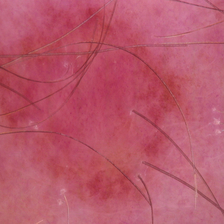

In [3]:
random_image = Image.open("../dataset/CancerDetection/benign/3.jpg").resize(IMAGE_SHAPE)
random_image

In [4]:
data_dir = '..\\dataset\\CancerDetection'

In [5]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('../dataset/CancerDetection')

In [6]:
list(data_dir.glob('*/*.jpg'))[:5]

[WindowsPath('../dataset/CancerDetection/benign/1.jpg'),
 WindowsPath('../dataset/CancerDetection/benign/10.jpg'),
 WindowsPath('../dataset/CancerDetection/benign/100.jpg'),
 WindowsPath('../dataset/CancerDetection/benign/1000.jpg'),
 WindowsPath('../dataset/CancerDetection/benign/1001.jpg')]

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3297


In [8]:
benign_samples = list(data_dir.glob('benign/*'))
benign_samples[:5]

[WindowsPath('../dataset/CancerDetection/benign/1.jpg'),
 WindowsPath('../dataset/CancerDetection/benign/10.jpg'),
 WindowsPath('../dataset/CancerDetection/benign/100.jpg'),
 WindowsPath('../dataset/CancerDetection/benign/1000.jpg'),
 WindowsPath('../dataset/CancerDetection/benign/1001.jpg')]

In [9]:
malignant_samples = list(data_dir.glob('malignant/*'))
malignant_samples[:5]

[WindowsPath('../dataset/CancerDetection/malignant/1.jpg'),
 WindowsPath('../dataset/CancerDetection/malignant/10.jpg'),
 WindowsPath('../dataset/CancerDetection/malignant/100.jpg'),
 WindowsPath('../dataset/CancerDetection/malignant/1000.jpg'),
 WindowsPath('../dataset/CancerDetection/malignant/1001.jpg')]

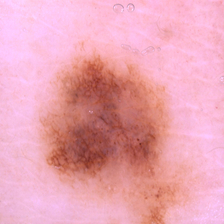

In [10]:
Image.open(str(benign_samples[1]))

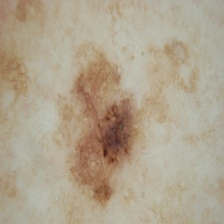

In [11]:
Image.open(str(malignant_samples[1]))

## Reading lesion images from disk into numpy array using opencv


In [12]:
skin_images_dict = {
    'benign': list(data_dir.glob('benign/*')),
    'malignant': list(data_dir.glob('malignant/*')),
}

In [13]:
skin_labels_dict = {
    'benign': 0,
    'malignant': 1,
}

In [14]:
skin_images_dict['malignant'][:5]

[WindowsPath('../dataset/CancerDetection/malignant/1.jpg'),
 WindowsPath('../dataset/CancerDetection/malignant/10.jpg'),
 WindowsPath('../dataset/CancerDetection/malignant/100.jpg'),
 WindowsPath('../dataset/CancerDetection/malignant/1000.jpg'),
 WindowsPath('../dataset/CancerDetection/malignant/1001.jpg')]

In [15]:
str(skin_images_dict['malignant'][0])

'..\\dataset\\CancerDetection\\malignant\\1.jpg'

In [16]:
img = cv2.imread(str(skin_images_dict['malignant'][0]))

In [17]:
img.shape

(224, 224, 3)

In [18]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [19]:
X, y = [], []

for cancer_name, images in skin_images_dict.items():
    
    for image in images:
        
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(skin_labels_dict[cancer_name])

In [20]:
X = np.array(X)
y = np.array(y)

## Train test split

In [21]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

## Preprocessing: scale images

In [22]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

## Make prediction using pre-trained model on new dataset

In [23]:
X[0].shape

(224, 224, 3)

In [24]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [25]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

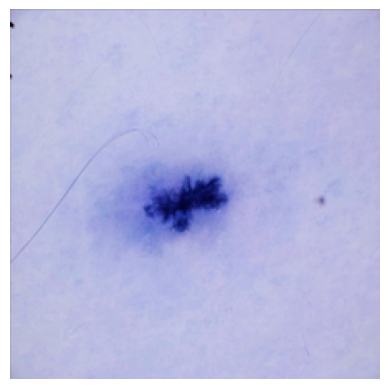

In [26]:
plt.axis('off')
plt.imshow(X[0])

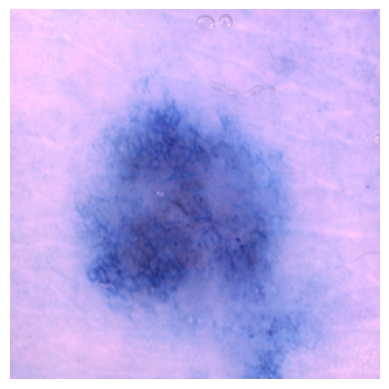

In [27]:
plt.axis('off')
plt.imshow(X[1])

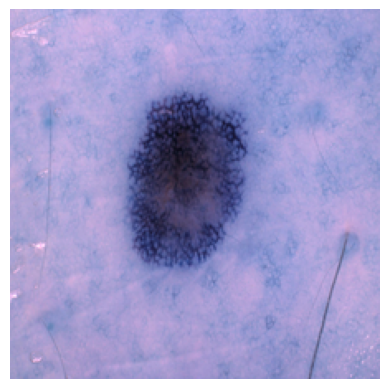

In [28]:
plt.axis('off')
plt.imshow(X[2])

In [29]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 [==============================] - 2s 2s/step


array([795, 795, 795], dtype=int64)

In [30]:
# image_labels[795]

## Now take pre-trained model and retrain it using HAM10000 images

In [31]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [32]:
cancer_classes = 2

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(cancer_classes)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [33]:
t0 = time.time()

model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc']
)



history = model.fit(
    X_train_scaled, 
    y_train, 
    epochs=EPOCHS
)

t1 = time.time()

Epoch 1/50
78/78 [==============================] - 48s 571ms/step - loss: 0.4850 - acc: 0.7646
Epoch 2/50
78/78 [==============================] - 45s 575ms/step - loss: 0.3648 - acc: 0.8426
Epoch 3/50
78/78 [==============================] - 46s 587ms/step - loss: 0.3416 - acc: 0.8487
Epoch 4/50
78/78 [==============================] - 48s 614ms/step - loss: 0.3061 - acc: 0.8649
Epoch 5/50
78/78 [==============================] - 49s 633ms/step - loss: 0.2943 - acc: 0.8693
Epoch 6/50
78/78 [==============================] - 49s 633ms/step - loss: 0.2790 - acc: 0.8827
Epoch 7/50
78/78 [==============================] - 49s 622ms/step - loss: 0.2710 - acc: 0.8875
Epoch 8/50
78/78 [==============================] - 49s 626ms/step - loss: 0.2610 - acc: 0.8879
Epoch 9/50
78/78 [==============================] - 54s 690ms/step - loss: 0.2488 - acc: 0.8940
Epoch 10/50
78/78 [==============================] - 55s 699ms/step - loss: 0.2393 - acc: 0.8981
Epoch 11/50
78/78 [====================

## Training Time

In [34]:
print("Transfer Learning Model Training time:  ", (t1-t0)/60 , "minutes")

Transfer Learning Model Training time:   50.502716644605 minutes


## Evaluation

In [35]:
model.evaluate(X_test_scaled,y_test)

26/26 [==============================] - 21s 724ms/step - loss: 0.3799 - acc: 0.8582


[0.37987974286079407, 0.8581818342208862]

## Prediction

In [36]:
predicted = model.predict(X_test_scaled)

26/26 [==============================] - 18s 650ms/step


In [37]:
# print(predicted)
print(len(predicted))
print(len(y_test))

825
825


In [38]:
confidence = np.max(predicted, axis=1)
predictions = np.argmax(predicted, axis=1)

In [39]:
# print(predictions)
# print(y_test)

# Plotting History

In [40]:
acc = history.history['loss']
val_acc = history.history['acc']

Text(0.5, 1.0, 'Loss and Accuracy')

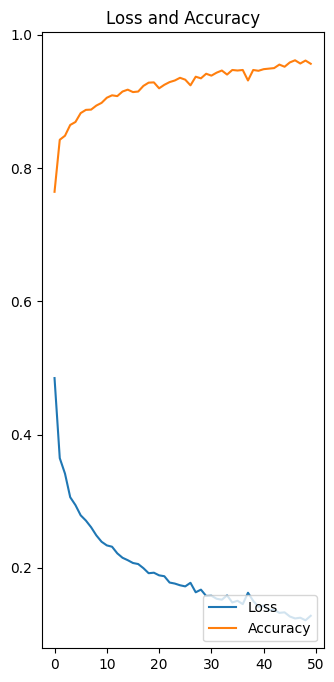

In [46]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Loss')
plt.plot(range(EPOCHS), val_acc, label='Accuracy')
plt.legend(loc='lower right')
plt.title('Loss and Accuracy')


## CONFUSION MATRIX

In [42]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

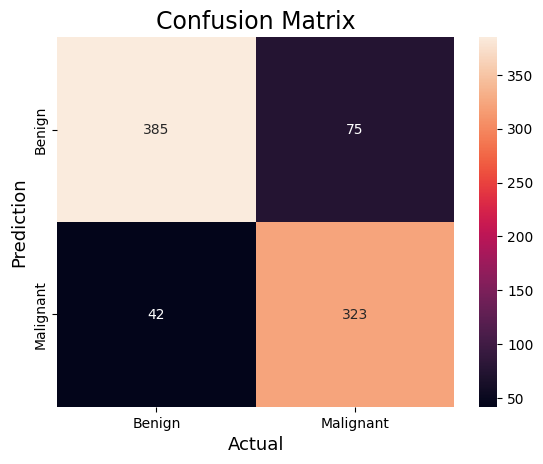

In [43]:
cm = confusion_matrix(y_test, predictions)


sns.heatmap(
    cm,
    annot=True,
    fmt='g',
    xticklabels=['Benign','Malignant'],
    yticklabels=['Benign','Malignant']
)

plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

In [44]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.90      0.84      0.87       460
           1       0.81      0.88      0.85       365

    accuracy                           0.86       825
   macro avg       0.86      0.86      0.86       825
weighted avg       0.86      0.86      0.86       825



# Saving the Model

In [45]:
import os
# model_version=max([int(i) for i in os.listdir("../transfer_savedmodels") + [0]])+1
model.save(f"../transfer_savedmodels/final.h5")